# King County Home Value Project Overview

 - This notebook will analyze data from the King County House Sales dataset. This dataset contains various information on homes in King County. I will use this data in order to create linear regression models with the purpose of determining which features are most relevant in predicting housing prices. I will then examine the models' output and compare and contrast to determine which model performs best according to the R-Squared and Mean Absolute Error metrics.

## Business Objective

 - Hypothetical Situation: A King County real estate agency is looking to provide advice to home owners on what factors are most important in determining the value of their home. Using several multiple linear regression models I will examine which independant variables are most useful at predicting the dependant variable of home price. The regression models will help in providing home owners with relevant information regarding the price of their home should they be interested in listing their home with the real estate agency. 

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from sklearn import metrics
from sklearn.neighbors import DistanceMetric
from math import radians
import warnings
import chart_studio.plotly as py
import cufflinks as cf
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
import plotly.express as px
init_notebook_mode(connected=True)
cf.go_offline()
warnings.filterwarnings('ignore')

## Functions

In [2]:
"""Filters columns of dataframe to only keep relevant features"""
def filter_columns(df):
    columns_to_keep = ['price','bedrooms', 
                   'bathrooms', 
                   'sqft_living', 
                   'sqft_lot', 
                   'floors', 
                   'condition',
                  'grade',
                  'sqft_above',
                  'yr_built',
                  'zipcode',
                       'sqft_living15',
                       'sqft_lot15',
                      'lat',
                      'long']
    return df[columns_to_keep]

In [3]:
"""Creates a histogram of the data"""
def histograms(data):
    fig = plt.figure(figsize = (20,12))
    ax = fig.gca()
    data.hist(ax = ax);

In [4]:
"""Creaes a distribution plot of the data"""
def check_dist(column, title):
    sns.distplot(df_filtered[column], kde=True).set(title=title);

In [5]:
"""Creates a boxplot of the data"""
def boxplot(x, title):
    sns.boxplot(x=x, y='price', data=df_filtered).set(title=title);

In [6]:
"""Creates a scatter plot of the residuals"""
def plot_scatter(y_test, resid, title):
    plt.figure(figsize=(12,8))
    plt.scatter(y_test, resid)
    plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
    plt.title(title);

In [7]:
"""Creates an ordinary least squares model from the training features"""
def ols_model(training_features):
    outcome = 'y_train'
    predictors = training_features
    pred_sum = '+'.join(predictors.columns)
    formula = outcome + '~' + pred_sum
    data = pd.concat([X_train, y_train], axis=1)
    model_ols = ols(formula=formula, data=data).fit()
    return model_ols.summary()

In [8]:
"""Creates an ordinary least squares model from the training features for y_train_2"""
def ols_model_2(training_features):
    outcome = 'y_train_2'
    predictors = training_features
    pred_sum = '+'.join(predictors.columns)
    formula = outcome + '~' + pred_sum
    data = pd.concat([X_train_2, y_train_2], axis=1)
    model_ols = ols(formula=formula, data=data).fit()
    return model_ols.summary()

In [9]:
"""Creates an ordinary least squares model from the training features for y_train_3"""
def ols_model_3(training_features):
    outcome = 'y_train_3'
    predictors = training_features
    pred_sum = '+'.join(predictors.columns)
    formula = outcome + '~' + pred_sum
    data_3 = pd.concat([X_train_3, y_train_3], axis=1)
    model_ols = ols(formula=formula, data=data_3).fit()
    return model_ols.summary()

In [10]:
"""Plots the model feature importance into a bar chart"""
def plot_feature_imp(data, model, title, title_2):
    feat_imps_df = pd.DataFrame(
    zip(data.columns, model.coef_),
    columns=['Feature', 'Importance'],
    )
    fig, ax = plt.subplots(figsize=(12,8))
    sns.barplot(x='Importance', y='Feature', 
            data=feat_imps_df.sort_values(by='Importance', key=abs, ascending=False), orient='h', ax=ax)
    plt.suptitle(title_2, fontsize=18)
    plt.title(title);

In [11]:
"""Plots the model's top ten features into a bar chart"""
def top_ten_features(model, features, columns, title):
    coef_df = pd.DataFrame(model.coef_, features.columns, columns = [columns]).sort_values(columns, ascending=False)
    coef_df_2 = coef_df[:10]
    ax = coef_df_2.sort_values(columns).plot.barh(y=columns, figsize=(12,8))
    plt.title(title)
    plt.xlabel('Importance');

In [12]:
"""Returns the MAE, MSE, and RMSE for the training and testing data"""
def errors(y_train, y_train_pred, y_test, y_test_pred):
    print('Train Mean Absolute Error:', round(metrics.mean_absolute_error(y_train, y_train_pred)))
    print('Test Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, y_test_pred)))
    print('Train Mean Squared Error:', round(metrics.mean_squared_error(y_train, y_train_pred)))
    print('Test Mean Squared Error:', round(metrics.mean_squared_error(y_test, y_test_pred)))
    print('Train Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))))
    print('Test Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))))

In [144]:
"""Plots the model's actual vs. predicted values into a scatter plot"""
def plot_model(test, test_pred, title, title_2):    
    plt.figure(figsize=(12,8))
    plt.scatter(test, test_pred)
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.suptitle(title_2, fontsize=18)
    plt.title(title, fontsize=16);

In [14]:
"""Returns the upper limit outliers for a given feature"""
def upper_outliers(feature):
    upper_limit = feature.mean() + 3*feature.std()
    return upper_limit

In [15]:
"""Returns the lower limit outliers for a given feature"""
def lower_outliers(feature):
    lower_limit = feature.mean() - 3*feature.std()
    return lower_limit

In [16]:
"""Returns the distance from Seattle for each home"""
def haversine_distance(lat1, lon1, lat2, lon2):
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2 - lat1)
   delta_lambda = np.radians(lon2 - lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res, 2)

## Data Description
The data used in this project will provide the following information:

 - ID - unique identified for a house

 - Date - house was sold

 - Price - is prediction target

 - Bedrooms - number of Bedrooms/House

 - Bathrooms - number of bathrooms/bedrooms

 - Sqft_livingsquare - footage of the home

 - Sqft_lotsquare - footage of the lot

 - FloorsTotal - floors (levels) in house

 - Waterfront - House which has a view to a waterfront

 - View - Has been viewed

 - Condition - How good the condition is ( Overall )

 - Grade - overall grade given to the housing unit, based on King County grading system

 - Sqft_above - square footage of house apart from basement

 - Sqft_basement - square footage of the basement

 - Yr_built - Built Year

 - Yr_renovated - Year when house was renovated

 - Zipcode - zip

 - Lat - Latitude coordinate

 - Long - Longitude coordinate

 - Sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors

 - Sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors

## Load Data

In [17]:
#Load the King County housing data for analysis.
df = pd.read_csv('data/kc_house_data.csv')

In [18]:
#Check shape of the data
df.shape

(21597, 21)

In [19]:
#Check head of the data
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [20]:
# Review remaining columns to see which ones make the most sense to keep.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

## Data Cleaning

In [21]:
#Review columns
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

Features to remove: 
- 'yr_renovated': large number of missing data.
- 'date': likely not relevant to business problem.
- 'id': likely not relevant to business problem.
- 'waterfront': large number of missing data.
- 'view': likely not relevant to business problem.
- 'yr_renovated': likely not relevant to business problem.

In [22]:
#Create new dataframe containing only relevant features
df_filtered = filter_columns(df)

In [23]:
#Review new dataframe for analysis
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   condition      21597 non-null  int64  
 7   grade          21597 non-null  int64  
 8   sqft_above     21597 non-null  int64  
 9   yr_built       21597 non-null  int64  
 10  zipcode        21597 non-null  int64  
 11  sqft_living15  21597 non-null  int64  
 12  sqft_lot15     21597 non-null  int64  
 13  lat            21597 non-null  float64
 14  long           21597 non-null  float64
dtypes: float64(5), int64(10)
memory usage: 2.5 MB


In [24]:
df_filtered.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,zipcode,sqft_living15,sqft_lot15,lat,long
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,3.409825,7.657915,1788.596842,1970.999676,98077.951845,1986.620318,12758.283512,47.560093,-122.213982
std,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.650546,1.173200,827.759761,29.375234,53.513072,685.230472,27274.441950,0.138552,0.140724
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,1.000000,3.000000,370.000000,1900.000000,98001.000000,399.000000,651.000000,47.155900,-122.519000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,3.000000,7.000000,1190.000000,1951.000000,98033.000000,1490.000000,5100.000000,47.471100,-122.328000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,3.000000,7.000000,1560.000000,1975.000000,98065.000000,1840.000000,7620.000000,47.571800,-122.231000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,4.000000,8.000000,2210.000000,1997.000000,98118.000000,2360.000000,10083.000000,47.678000,-122.125000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,5.000000,13.000000,9410.000000,2015.000000,98199.000000,6210.000000,871200.000000,47.777600,-121.315000


## Data Exploration

In [25]:
#Set graph style
plt.style.use('fivethirtyeight')

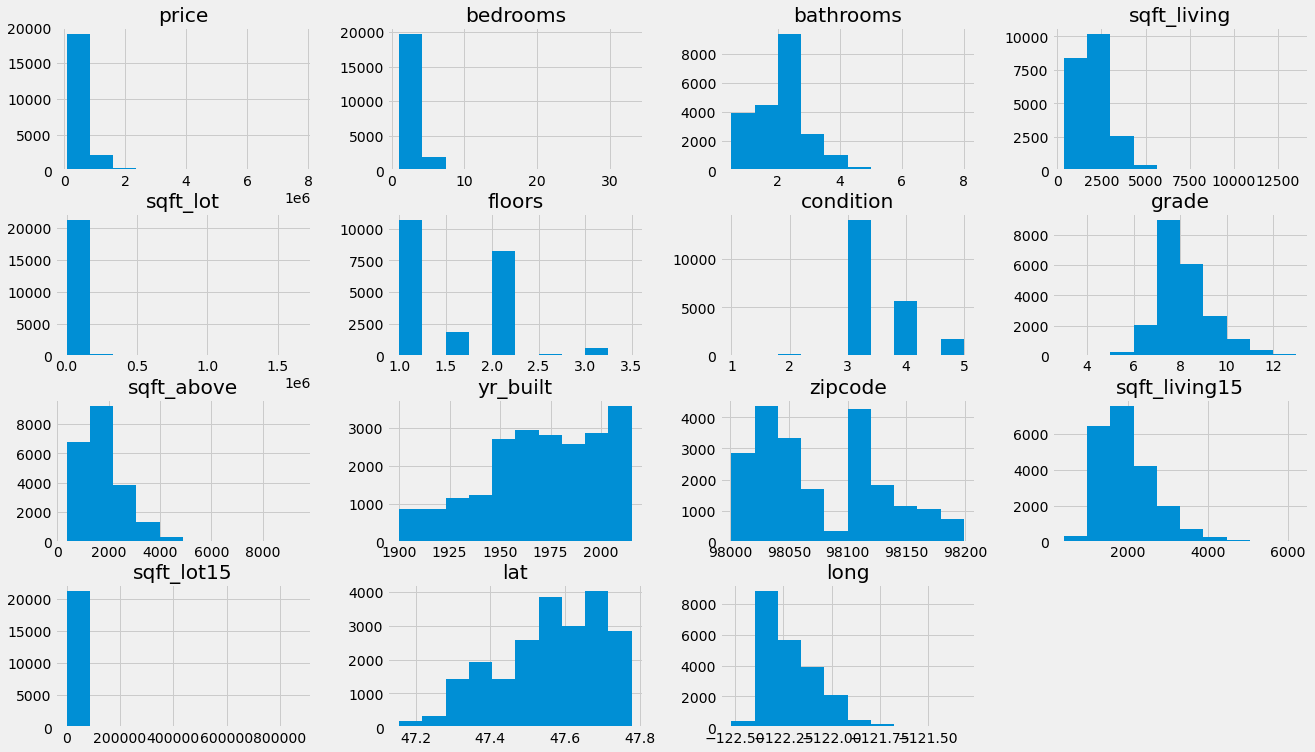

In [26]:
#Create histograms to analyze the distribution of the features:
histograms(df_filtered)

 - The data is not evenly distributed for several columns. Will analyze this further and need to address later on for increased model accuracy. 

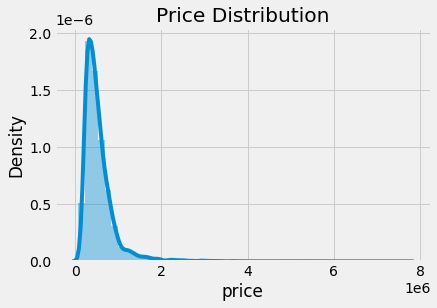

In [27]:
check_dist('price', 'Price Distribution')

 - Price contains outliers and is skewed to the right. Will address this by removing outliers later in the notebook.

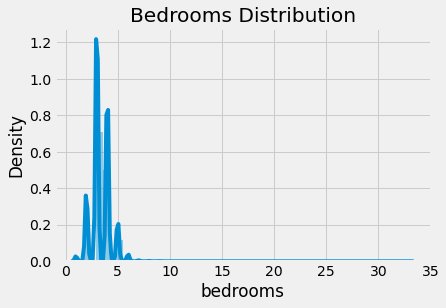

In [28]:
check_dist('bedrooms', 'Bedrooms Distribution')

 - Bedrooms also contains outliers and data is skewed to the right.

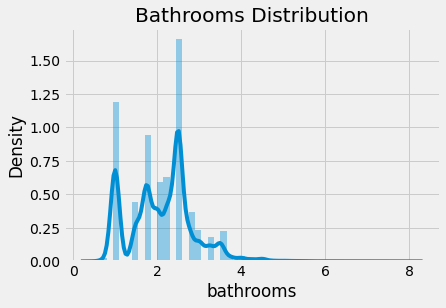

In [29]:
check_dist('bathrooms', 'Bathrooms Distribution')

 - Bathrooms contains outliers and data is skewed to the right.

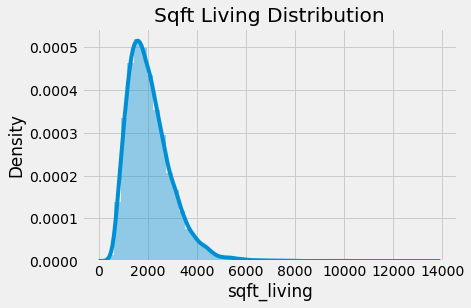

In [30]:
check_dist('sqft_living', 'Sqft Living Distribution')

 - Sqft Living contains outliers and data is skewed to the right.

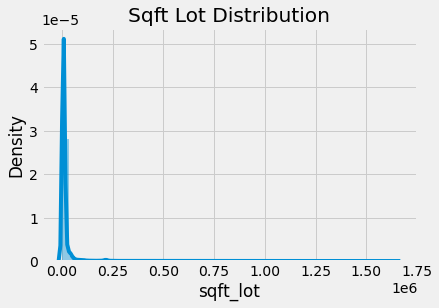

In [31]:
check_dist('sqft_lot', 'Sqft Lot Distribution')

 - Sqft lot contains outliers and is heavily skewed to the right.

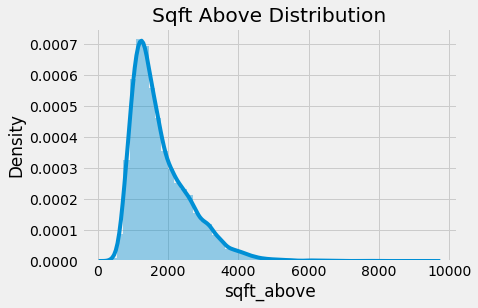

In [32]:
check_dist('sqft_above', 'Sqft Above Distribution')

 - Sqft above contains outliers and is slightly skewed to the right. 

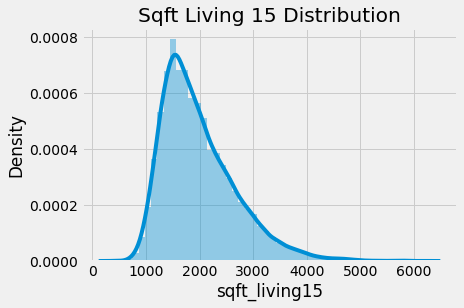

In [33]:
check_dist('sqft_living15', 'Sqft Living 15 Distribution')

 - Sqft Living 15 appears to be somewhat noramlly distributed though still slightly skewed to the right.

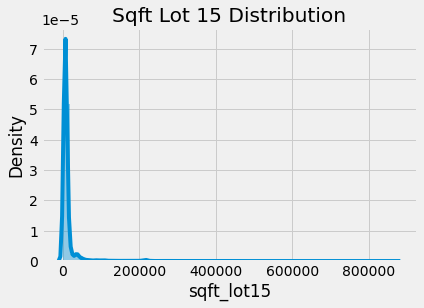

In [34]:
check_dist('sqft_lot15', 'Sqft Lot 15 Distribution')

 - Sqft lot 15 is also heavily skewed to the right containing many outliers.

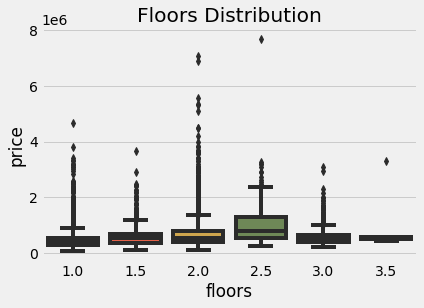

In [35]:
boxplot('floors', 'Floors Distribution')

 - Floors could be considered a categorical feature.

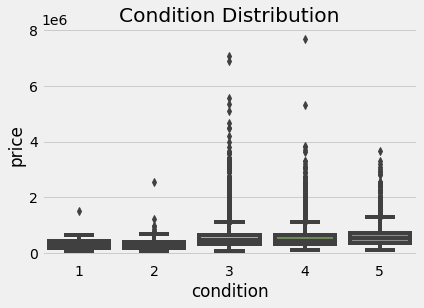

In [36]:
boxplot('condition', 'Condition Distribution')

 - Condition could be considered a categorical feature.

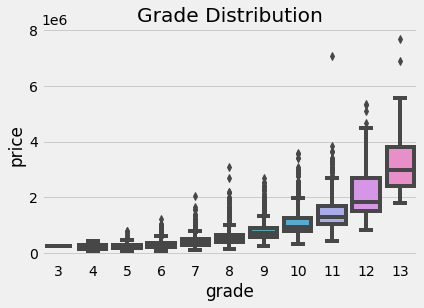

In [37]:
boxplot('grade', 'Grade Distribution')

 - 'bedrooms', 'bathrooms', 'zipcode', 'floors', and 'condition' could be considered categorical data, which will need to be addressed later. Will likely leave 'grade' as numerical data since it appears that a higher grade equates to a higher home price.

### Check for Multicollinearity

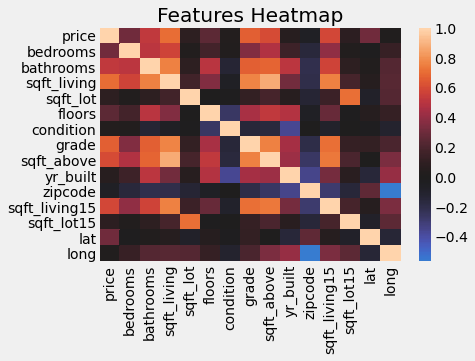

In [38]:
#Created heatmap to determine the multicollinearity of the features. 
sns.heatmap(df_filtered.corr(), center=0).set(title='Features Heatmap');

 - Several features such as sqft_lot and sqft_lot15 are closely related to each other and will need to be seperated when building models in order to prevent multicollinearity.

# Model A (Vanilla Classifier)

 - Will create a basic model without transforming any features to get an idea of how the data performs. 

In [39]:
df_filtered['zipcode'] = df_filtered['zipcode'].astype('str')
df_filtered['yr_built'] = df_filtered['yr_built'].astype('int64')

In [40]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
ohe_df = pd.DataFrame(ohe.fit_transform(df_filtered[['zipcode']]))
ohe_df.columns = ohe.get_feature_names(['zipcode'])
df_filtered.drop(['zipcode'] ,axis=1, inplace=True)
ohe_df = pd.concat([df_filtered.reset_index(drop=True), ohe_df.reset_index(drop=True)],axis=1)
ohe_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,221900.0,3,1.00,1180,5650,1.0,3,7,1180,1955,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,538000.0,3,2.25,2570,7242,2.0,3,7,2170,1951,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,180000.0,2,1.00,770,10000,1.0,3,6,770,1933,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,604000.0,4,3.00,1960,5000,1.0,5,7,1050,1965,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,510000.0,3,2.00,1680,8080,1.0,3,8,1680,1987,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Split Data into Training and Test set

In [41]:
#Seperate data into training and testing sets for analysis:
y = ohe_df['price']
X = ohe_df.drop(['price'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.2, random_state=42)

In [42]:
X_train.shape, y_train.shape

((17277, 83), (17277,))

In [43]:
X_test.shape, y_test.shape

((4320, 83), (4320,))

In [44]:
#Check features:
X_train.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'condition', 'grade', 'sqft_above', 'yr_built', 'sqft_living15',
       'sqft_lot15', 'lat', 'long', 'zipcode_98001', 'zipcode_98002',
       'zipcode_98003', 'zipcode_98004', 'zipcode_98005', 'zipcode_98006',
       'zipcode_98007', 'zipcode_98008', 'zipcode_98010', 'zipcode_98011',
       'zipcode_98014', 'zipcode_98019', 'zipcode_98022', 'zipcode_98023',
       'zipcode_98024', 'zipcode_98027', 'zipcode_98028', 'zipcode_98029',
       'zipcode_98030', 'zipcode_98031', 'zipcode_98032', 'zipcode_98033',
       'zipcode_98034', 'zipcode_98038', 'zipcode_98039', 'zipcode_98040',
       'zipcode_98042', 'zipcode_98045', 'zipcode_98052', 'zipcode_98053',
       'zipcode_98055', 'zipcode_98056', 'zipcode_98058', 'zipcode_98059',
       'zipcode_98065', 'zipcode_98070', 'zipcode_98072', 'zipcode_98074',
       'zipcode_98075', 'zipcode_98077', 'zipcode_98092', 'zipcode_98102',
       'zipcode_98103', 'zipcode_98105'

In [45]:
#Model A feature selection:
features_train_a = pd.DataFrame(data=X_train, columns=['bedrooms', 'bathrooms', 'sqft_living', 'grade', 'sqft_lot', 'floors', 'condition', 'yr_built'])
features_test_a = pd.DataFrame(data=X_test, columns=['bedrooms', 'bathrooms', 'sqft_living', 'grade', 'sqft_lot', 'floors', 'condition', 'yr_built'])

In [46]:
#Scale testing and training features
scale_features = StandardScaler()
scale_features.fit(features_train_a)
X_train_scaled_a = scale_features.transform(features_train_a)
X_test_scaled_a = scale_features.transform(features_test_a)

In [47]:
X_train_scaled_a = pd.DataFrame(X_train_scaled_a, columns = features_train_a.columns)
X_train_scaled_a.head()

,bedrooms,bathrooms,sqft_living,grade,sqft_lot,floors,condition,yr_built
0,0.691203,-0.149233,-0.701342,-0.562768,-0.252125,0.933592,0.905470,0.035248
1,-0.414530,-0.474899,-0.712241,-0.562768,-0.127687,-0.915081,0.905470,0.307771
2,0.691203,0.827764,1.129672,1.148415,-0.248518,0.933592,-0.631098,1.329731
3,0.691203,0.502099,-0.025611,-0.562768,-0.199807,-0.915081,-0.631098,0.103379
4,-0.414530,-0.149233,0.453941,-0.562768,-0.271405,0.009256,2.442038,-1.668018


## Model A Training

In [48]:
ols_model(X_train_scaled_a)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                y_train   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     3560.
Date:                Thu, 11 Nov 2021   Prob (F-statistic):               0.00
Time:                        10:05:43   Log-Likelihood:            -2.3756e+05
No. Observations:               17277   AIC:                         4.751e+05
Df Residuals:                   17268   BIC:                         4.752e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    7.082e+06    1.5e+05     47.243      0.000    6.79e+06    7.38e+06
bedrooms    -5.321e+04   2462.364    -21.607      0.000    -5.8e+04   -4.84e+04
bathrooms     5.59e+04   4021.141     13.901      0.000     4.8e+04    6.38e+04
sqft_living   188.6280      3.860     48.861      0.000     181.061     196.195
grade        1.325e+05   2502.162     52.947      0.000    1.28e+05    1.37e+05
sqft_lot       -0.2984      0.044     -6.779      0.000      -0.385      -0.212
floors       2.227e+04   3998.403      5.569      0.000    1.44e+04    3.01e+04
condition    2.134e+04   2883.721      7.400      0.000    1.57e+04     2.7e+04
yr_built    -4053.0035     76.984    -52.648      0.000   -4203.899   -3902.108
==============================================================================
Omnibus:                    13250.093   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           759153.423
Skew:                           3.188   Prob(JB):                         0.00
Kurtosis:                      34.842   Cond. No.                     3.73e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.73e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [49]:
model_a = LinearRegression()
model_a.fit(X_train_scaled_a, y_train)

LinearRegression()

## Model A Evaluation

In [50]:
#Model A Intercept
print(model_a.intercept_)

541519.0094345086


In [51]:
#Model A Coefficients
coef_df_a = pd.DataFrame(model_a.coef_, features_train_a.columns, columns = ['Model A Coefficents'])
coef_df_a

,Model A Coefficents
bedrooms,-48117.413095
bathrooms,42909.230388
sqft_living,173070.842365
grade,154842.820888
sqft_lot,-11995.016652
floors,12044.331419
condition,13887.385310
yr_built,-118977.378775


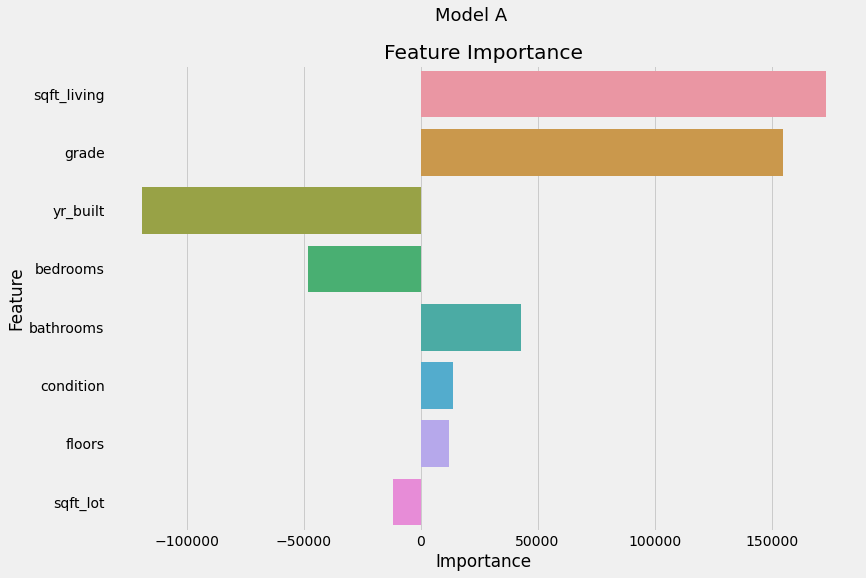

In [52]:
plot_feature_imp(features_train_a, model_a, 'Feature Importance', 'Model A')

 - According to Model A the top feature for determining price is square foot living, followed by grade and year built.

In [53]:
#Run model on training and testing data.
y_train_pred_a = model_a.predict(X_train_scaled_a)
y_test_pred_a = model_a.predict(X_test_scaled_a)

In [54]:
errors(y_train, y_train_pred_a, y_test, y_test_pred_a)

Train Mean Absolute Error: 145549
Test Mean Absolute Error: 145718
Train Mean Squared Error: 51380886645
Test Mean Squared Error: 52412387312
Train Root Mean Squared Error: 226674
Test Root Mean Squared Error: 228938


 - On average Model A predicts home prices within $145,718 of the true value.

In [55]:
#Calculate Model A residuals in order to use for graphs.
resid_a = y_test_pred_a - y_test

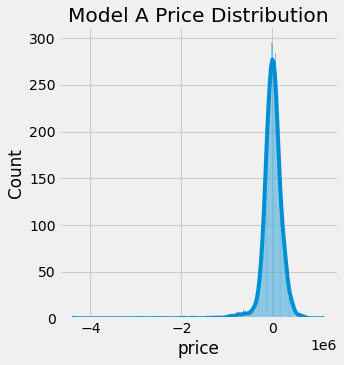

In [56]:
#Create distribution plot to check Model A's distribution of prices.
sns.displot(x=resid_a,kind='hist',kde=True)
plt.title('Model A Price Distribution');

 - Model A's distribution shows a long tail in the lower price range to the left of the median price, likely indicating the prescence of outliers and confirming that the data is not evenly distributed.

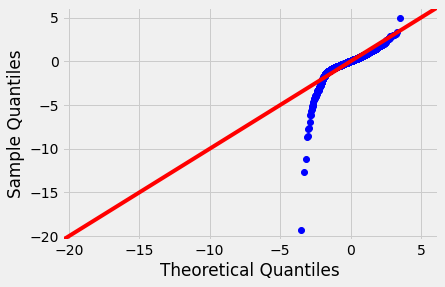

In [57]:
#Create qq plot to further analyze the distribution of the data.
fig = sm.graphics.qqplot(resid_a, dist=stats.norm, line='45',fit=True)

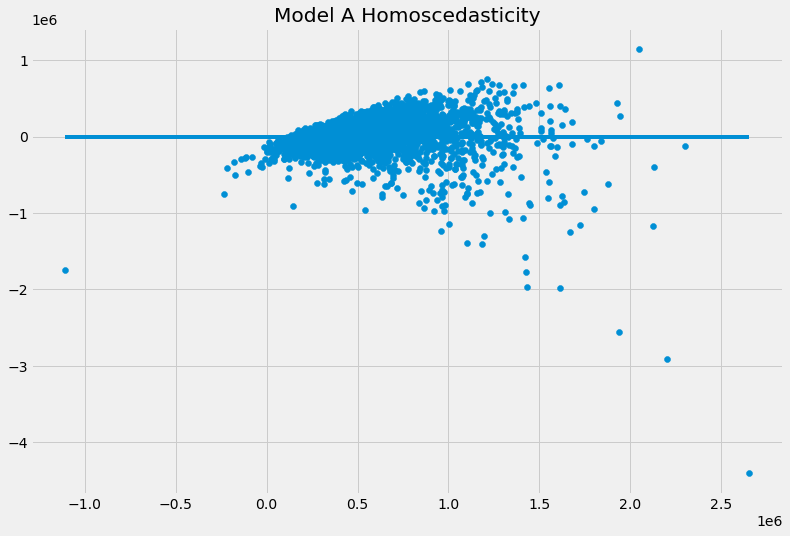

In [58]:
plot_scatter(y_test_pred_a, resid_a, 'Model A Homoscedasticity')

 - The data appears to be bunched to the left making it heteroscedastic. Will likely need to remove outliers in order to prevent this for future models.

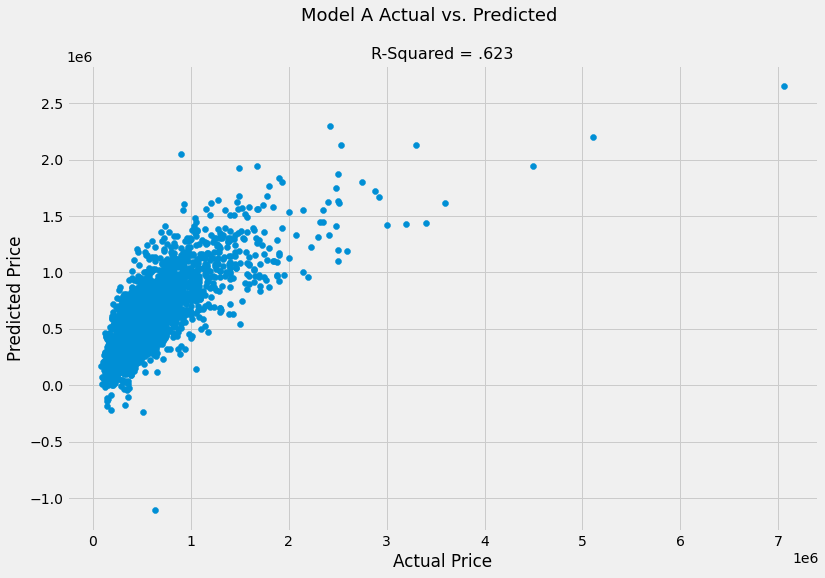

In [145]:
plot_model(y_test, y_test_pred_a, 'R-Squared = .623', 'Model A Actual vs. Predicted')

 - The actual vs. predicted chart shows that Model A does not appear to follow a strong linear pattern. 

# Model B

 - Model B will include the categorical zip code features created earlier in the notebook.

## Model B Training

In [60]:
#Model B training & testing features:
features_train_b = X_train.drop(['sqft_lot', 'floors', 'condition', 'grade', 'sqft_above', 'sqft_living15',
                            'sqft_lot15', 'lat', 'long'], axis=1)
features_test_b = X_test.drop(['sqft_lot', 'floors', 'condition', 'grade', 'sqft_above', 'sqft_living15',
                            'sqft_lot15', 'lat', 'long'], axis=1)

In [61]:
#Scale testing and training features
scale_features = StandardScaler()
scale_features.fit(features_train_b)
X_train_scaled_b = scale_features.transform(features_train_b)
X_test_scaled_b = scale_features.transform(features_test_b)

In [62]:
X_train_scaled_b = pd.DataFrame(X_train_scaled_b, columns = features_train_b.columns)
X_train_scaled_b.head()

,bedrooms,bathrooms,sqft_living,yr_built,zipcode_98001,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,0.691203,-0.149233,-0.701342,0.035248,-0.129046,-0.093899,-0.113569,-0.120925,-0.089074,-0.150769,...,-0.114091,-0.053331,-0.143585,-0.111725,-0.110658,-0.108494,-0.112782,-0.080413,-0.114091,-0.123849
1,-0.414530,-0.474899,-0.712241,0.307771,-0.129046,-0.093899,-0.113569,-0.120925,-0.089074,-0.150769,...,-0.114091,-0.053331,-0.143585,-0.111725,-0.110658,-0.108494,-0.112782,-0.080413,-0.114091,-0.123849
2,0.691203,0.827764,1.129672,1.329731,-0.129046,-0.093899,-0.113569,-0.120925,-0.089074,-0.150769,...,-0.114091,-0.053331,-0.143585,-0.111725,-0.110658,-0.108494,-0.112782,-0.080413,-0.114091,-0.123849
3,0.691203,0.502099,-0.025611,0.103379,-0.129046,-0.093899,-0.113569,-0.120925,-0.089074,-0.150769,...,-0.114091,-0.053331,-0.143585,-0.111725,-0.110658,-0.108494,-0.112782,-0.080413,-0.114091,-0.123849
4,-0.414530,-0.149233,0.453941,-1.668018,-0.129046,-0.093899,-0.113569,-0.120925,-0.089074,-0.150769,...,-0.114091,-0.053331,-0.143585,-0.111725,-0.110658,-0.108494,-0.112782,-0.080413,-0.114091,-0.123849


In [63]:
#Create Model B OLS model 
ols_model(X_train_scaled_b)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                y_train   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     685.5
Date:                Thu, 11 Nov 2021   Prob (F-statistic):               0.00
Time:                        10:05:46   Log-Likelihood:            -2.3420e+05
No. Observations:               17277   AIC:                         4.686e+05
Df Residuals:                   17203   BIC:                         4.691e+05
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.803e+06   1.28e+05     14.066      0.000    1.55e+06    2.05e+06
bedrooms       -5.27e+04   2037.877    -25.862      0.000   -5.67e+04   -4.87e+04
bathrooms      2.997e+04   3320.305      9.025      0.000    2.35e+04    3.65e+04
sqft_living     271.2184      2.694    100.682      0.000     265.938     276.499
yr_built       -874.4630     66.778    -13.095      0.000   -1005.354    -743.572
zipcode_98001 -1.936e+05   1.14e+04    -16.992      0.000   -2.16e+05   -1.71e+05
zipcode_98002 -1.691e+05   1.53e+04    -11.082      0.000   -1.99e+05   -1.39e+05
zipcode_98003 -1.789e+05   1.28e+04    -14.015      0.000   -2.04e+05   -1.54e+05
zipcode_98004  5.855e+05    1.2e+04     48.809      0.000    5.62e+05    6.09e+05
zipcode_98005  1.487e+05    1.6e+04      9.288      0.000    1.17e+05     1.8e+05
zipcode_98006  1.231e+05   9876.253     12.464      0.000    1.04e+05    1.42e+05
zipcode_98007  8.007e+04   1.76e+04      4.562      0.000    4.57e+04    1.14e+05
zipcode_98008    1.2e+05   1.24e+04      9.687      0.000    9.57e+04    1.44e+05
zipcode_98010 -1.162e+05   2.04e+04     -5.708      0.000   -1.56e+05   -7.63e+04
zipcode_98011 -7.505e+04   1.53e+04     -4.917      0.000   -1.05e+05   -4.51e+04
zipcode_98014 -9.765e+04   1.81e+04     -5.395      0.000   -1.33e+05   -6.22e+04
zipcode_98019 -1.214e+05   1.54e+04     -7.857      0.000   -1.52e+05   -9.11e+04
zipcode_98022 -1.474e+05   1.38e+04    -10.660      0.000   -1.74e+05    -1.2e+05
zipcode_98023 -2.046e+05   9570.404    -21.382      0.000   -2.23e+05   -1.86e+05
zipcode_98024  -2.51e+04   2.22e+04     -1.132      0.258   -6.86e+04    1.84e+04
zipcode_98027 -2.076e+04   1.04e+04     -1.990      0.047   -4.12e+04    -307.243
zipcode_98028 -7.405e+04   1.26e+04     -5.855      0.000   -9.88e+04   -4.93e+04
zipcode_98029  4.306e+04   1.21e+04      3.551      0.000    1.93e+04    6.68e+04
zipcode_98030 -1.837e+05   1.35e+04    -13.601      0.000    -2.1e+05   -1.57e+05
zipcode_98031  -1.74e+05   1.27e+04    -13.692      0.000   -1.99e+05   -1.49e+05
zipcode_98032  -1.83e+05   1.87e+04     -9.810      0.000    -2.2e+05   -1.46e+05
zipcode_98033  1.951e+05   1.05e+04     18.601      0.000    1.75e+05    2.16e+05
zipcode_98034  3.224e+04   9077.292      3.551      0.000    1.44e+04       5e+04
zipcode_98038 -1.681e+05   9315.341    -18.048      0.000   -1.86e+05    -1.5e+05
zipcode_98039  1.213e+06   2.81e+04     43.217      0.000    1.16e+06    1.27e+06
zipcode_98040  4.173e+05   1.26e+04     33.069      0.000    3.93e+05    4.42e+05
zipcode_98042 -1.744e+05   9445.444    -18.464      0.000   -1.93e+05   -1.56e+05
zipcode_98045 -8.102e+04   1.38e+04     -5.865      0.000   -1.08e+05   -5.39e+04
zipcode_98052  5.383e+04   9144.309      5.887      0.000    3.59e+04    7.18e+04
zipcode_98053  7500.0957   1.12e+04      0.673   

In [64]:
#Create linear regression model using Sklearn
model_b_lr = LinearRegression()
model_b_lr.fit(X_train_scaled_b, y_train)

LinearRegression()

## Model B Evaluation

In [65]:
#Model B Intercept
print(model_b_lr.intercept_)

541623.2953379083


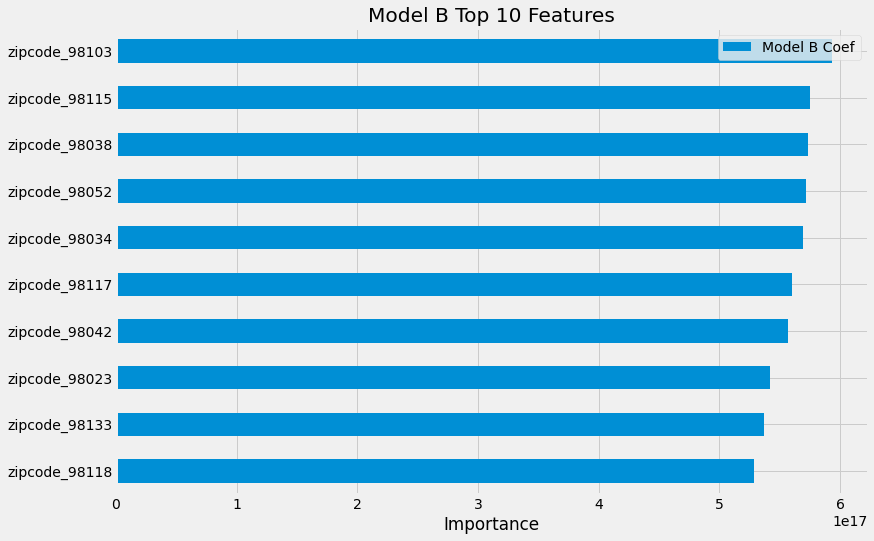

In [66]:
top_ten_features(model_b_lr, features_train_b, 'Model B Coef', 'Model B Top 10 Features')

 - According to Model B the top ten features for determining price are all zip codes.

In [67]:
#Run model on training and testing data.
y_train_pred_b = model_b_lr.predict(X_train_scaled_b)
y_test_pred_b = model_b_lr.predict(X_test_scaled_b)

In [68]:
errors(y_train, y_train_pred_b, y_test, y_test_pred_b)

Train Mean Absolute Error: 110557
Test Mean Absolute Error: 109632
Train Mean Squared Error: 34831426878
Test Mean Squared Error: 35611489665
Train Root Mean Squared Error: 186632
Test Root Mean Squared Error: 188710


 - On average Model B predicts home prices within $109,632 of the true home value.

In [69]:
#Calculate Model B residuals in order to use for graphs.
resid_b = y_test_pred_b - y_test

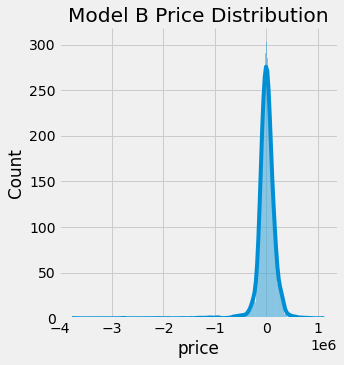

In [70]:
#Create distribution plot to check Model B's distribution of prices.
sns.displot(x=resid_b,kind='hist',kde=True)
plt.title('Model B Price Distribution');

 - Similar to Model A, Model B's distribution also shows a long tail in the lower price range to the left of the median price, likely indicating the prescence of outliers and confirming that the data is not evenly distributed.

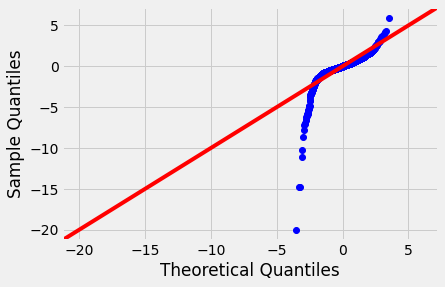

In [71]:
#Create qq plot to further analyze the distribution of the data.
fig = sm.graphics.qqplot(resid_b, dist=stats.norm, line='45',fit=True)

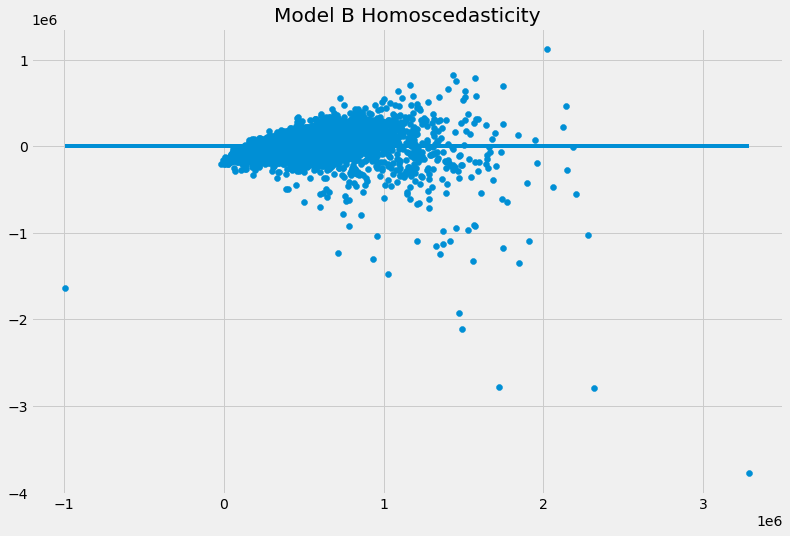

In [72]:
plot_scatter(y_test_pred_b, resid_b, 'Model B Homoscedasticity')

- Model B's data also appears to be bunched to the left making it heteroscedastic. Will remove outliers in the next model to help improve this.

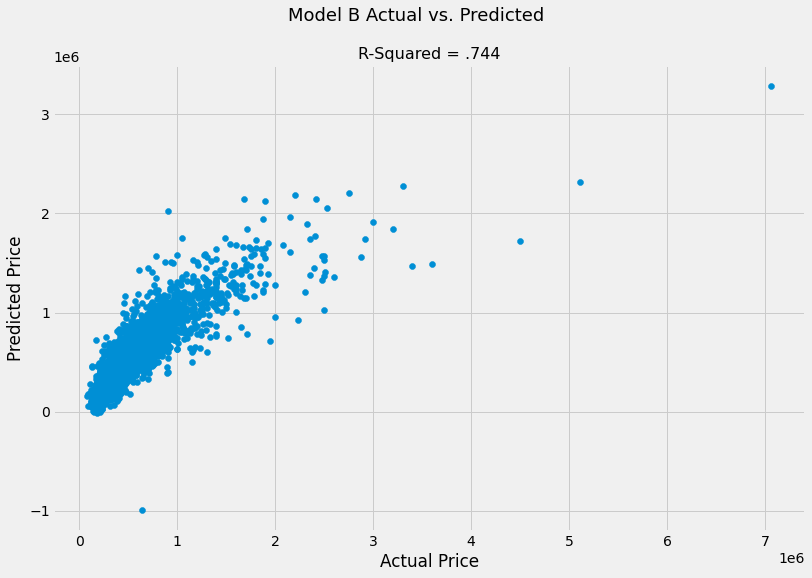

In [146]:
plot_model(y_test, y_test_pred_b, 'R-Squared = .744', 'Model B Actual vs. Predicted')

- Similar to Model A, Model B also does not appear to follow a strong linear pattern. The next model will remove outliers from the data to see if this improves model performance. 

# Model C

 - Model C will contain the same features as Model B except with removed outliers in order to help improve model accuracy. 

## Remove Outliers

 - Will remove outliers for certain features in order to make the data more normally distributed and address high skewness and kurtosis from Model's A and B.

In [74]:
#Find the upper limit of three standard deviations for 'bathrooms'
upper_limit_baths = upper_outliers(ohe_df.bathrooms)
upper_limit_baths

4.422779162125593

In [75]:
#Find the upper limit of three standard deviations for 'bedrooms'
upper_limit_beds = upper_outliers(ohe_df.bedrooms)
upper_limit_beds

6.152096665105352

In [76]:
#Find the lower limit of three standard deviations for 'bedrooms'
lower_limit_beds = lower_outliers(ohe_df.bedrooms)
lower_limit_beds

0.5943032978524658

In [77]:
#Find the lower limit of three deviations for 'bathrooms'
lower_limit_baths = lower_outliers(ohe_df.bathrooms)
lower_limit_baths

-0.19112661779073248

In [78]:
#Find the upper limit of three standard deviations for 'price'
upper_limit_price = upper_outliers(ohe_df.price)
upper_limit_price

1642400.9938097629

In [79]:
#Find the lower limit of three standard deviations for 'price'
lower_limit_price = lower_outliers(ohe_df.price)
lower_limit_price

-561807.8467986039

In [80]:
upper_limit_sqft = upper_outliers(ohe_df.sqft_living)
upper_limit_sqft

4834.640225497222

In [81]:
lower_limit_sqft = lower_outliers(ohe_df.sqft_living)
lower_limit_sqft

-673.9965249832612

In [82]:
upper_limit_lot = upper_outliers(ohe_df.sqft_lot)
upper_limit_lot

139337.3193869822

In [83]:
lower_limit_lot = lower_outliers(ohe_df.sqft_lot)
lower_limit_lot

-109138.50186603024

In [84]:
upper_limit_sqft15 = upper_outliers(ohe_df.sqft_living15)
upper_limit_sqft15

4042.3117333371847

In [85]:
lower_limit_sqft15 = lower_outliers(ohe_df.sqft_living15)
lower_limit_sqft15

-69.07109806376707

In [86]:
outliers_df_2 = ohe_df[(ohe_df.bathrooms<upper_limit_baths) & (ohe_df.bathrooms>lower_limit_baths) 
                        & (ohe_df.bedrooms<upper_limit_beds) & (ohe_df.bedrooms>lower_limit_beds) &
                 (ohe_df.sqft_living<upper_limit_sqft) & (ohe_df.sqft_living>lower_limit_sqft) &
                (ohe_df.sqft_lot<upper_limit_lot) & (ohe_df.sqft_lot>lower_limit_lot) &
                 (ohe_df.sqft_living15<upper_limit_sqft15) & (ohe_df.sqft_living15>lower_limit_sqft15) & 
                        (ohe_df.price<upper_limit_price) & (ohe_df.price>lower_limit_price)]

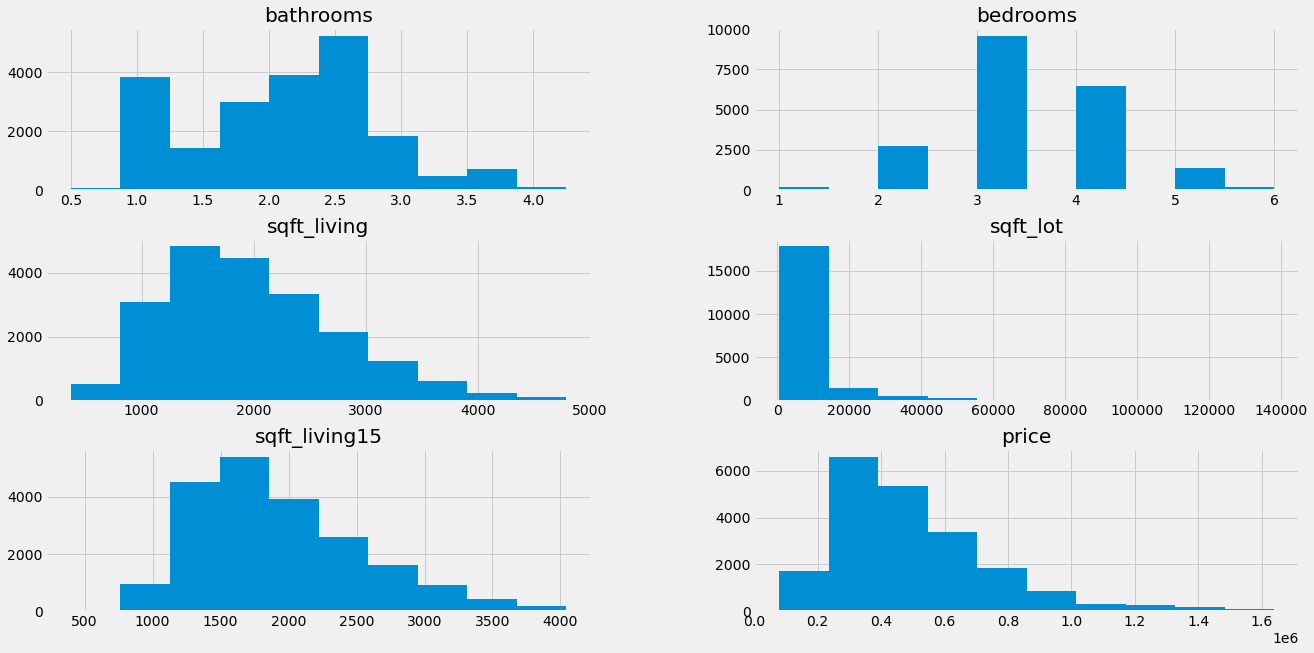

In [87]:
#Check new distributions of the features.
fig = plt.figure(figsize = (20,10))
ax = fig.gca()
outliers_df_2[['bathrooms', 'bedrooms', 'sqft_living', 'sqft_lot', 'sqft_living15', 'price']].hist(ax = ax);

 - The features appear to be more evenly distributed after removing outliers, except for square foot lot which still contains outliers in the right tail.

In [88]:
#Seperate data into training and testing sets for analysis:
y = outliers_df_2['price']
X = outliers_df_2.drop(['price'], axis=1)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X , y, test_size=0.2, random_state=42)

In [89]:
#Model C training & testing features:
features_train_c = X_train_2.drop(['sqft_lot', 'floors', 'condition', 'grade', 'sqft_above', 'sqft_living15',
                            'sqft_lot15', 'lat', 'long', 
                                 'zipcode_98024', 'zipcode_98053', 'zipcode_98070', 'zipcode_98126'], axis=1)
features_test_c = X_test_2.drop(['sqft_lot', 'floors', 'condition', 'grade', 'sqft_above', 'sqft_living15',
                            'sqft_lot15', 'lat', 'long', 
                                 'zipcode_98024', 'zipcode_98053', 'zipcode_98070', 'zipcode_98126'], axis=1)

In [90]:
#Scale testing and training features
scale_features = StandardScaler()
scale_features.fit(features_train_c)
X_train_scaled_c = scale_features.transform(features_train_c)
X_test_scaled_c = scale_features.transform(features_test_c)

In [91]:
X_train_scaled_c = pd.DataFrame(X_train_scaled_c, columns = features_train_c.columns)

## Model C Training

In [92]:
#Creat Model C OLS model.
ols_model(X_train_scaled_c)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                y_train   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     714.8
Date:                Thu, 11 Nov 2021   Prob (F-statistic):               0.00
Time:                        10:05:53   Log-Likelihood:            -2.3420e+05
No. Observations:               17277   AIC:                         4.686e+05
Df Residuals:                   17206   BIC:                         4.691e+05
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.796e+06   1.29e+05     13.908      0.000    1.54e+06    2.05e+06
bedrooms      -5.271e+04   2037.186    -25.874      0.000   -5.67e+04   -4.87e+04
bathrooms      2.992e+04   3317.057      9.021      0.000    2.34e+04    3.64e+04
sqft_living     271.2321      2.683    101.105      0.000     265.974     276.490
yr_built       -870.1276     66.081    -13.168      0.000    -999.652    -740.603
zipcode_98001 -1.942e+05   1.31e+04    -14.807      0.000    -2.2e+05   -1.68e+05
zipcode_98002 -1.696e+05   1.68e+04    -10.122      0.000   -2.02e+05   -1.37e+05
zipcode_98003 -1.794e+05   1.44e+04    -12.464      0.000   -2.08e+05   -1.51e+05
zipcode_98004   5.85e+05   1.38e+04     42.460      0.000    5.58e+05    6.12e+05
zipcode_98005  1.482e+05   1.75e+04      8.473      0.000    1.14e+05    1.83e+05
zipcode_98006  1.226e+05   1.18e+04     10.351      0.000    9.94e+04    1.46e+05
zipcode_98007  7.961e+04   1.89e+04      4.202      0.000    4.25e+04    1.17e+05
zipcode_98008  1.195e+05   1.42e+04      8.441      0.000    9.18e+04    1.47e+05
zipcode_98010 -1.167e+05   2.15e+04     -5.416      0.000   -1.59e+05   -7.45e+04
zipcode_98011 -7.557e+04   1.67e+04     -4.531      0.000   -1.08e+05   -4.29e+04
zipcode_98014 -9.818e+04   1.93e+04     -5.075      0.000   -1.36e+05   -6.03e+04
zipcode_98019 -1.219e+05   1.68e+04     -7.266      0.000   -1.55e+05    -8.9e+04
zipcode_98022 -1.479e+05   1.54e+04     -9.610      0.000   -1.78e+05   -1.18e+05
zipcode_98023 -2.051e+05   1.15e+04    -17.778      0.000   -2.28e+05   -1.83e+05
zipcode_98027  -2.13e+04   1.22e+04     -1.740      0.082   -4.53e+04    2700.426
zipcode_98028 -7.455e+04   1.43e+04     -5.220      0.000   -1.03e+05   -4.66e+04
zipcode_98029  4.249e+04   1.37e+04      3.105      0.002    1.57e+04    6.93e+04
zipcode_98030 -1.842e+05    1.5e+04    -12.268      0.000   -2.14e+05   -1.55e+05
zipcode_98031 -1.745e+05   1.43e+04    -12.187      0.000   -2.03e+05   -1.46e+05
zipcode_98032 -1.835e+05      2e+04     -9.184      0.000   -2.23e+05   -1.44e+05
zipcode_98033  1.946e+05   1.24e+04     15.734      0.000     1.7e+05    2.19e+05
zipcode_98034  3.174e+04   1.12e+04      2.840      0.005    9833.028    5.37e+04
zipcode_98038 -1.687e+05   1.12e+04    -15.098      0.000   -1.91e+05   -1.47e+05
zipcode_98039  1.213e+06   2.92e+04     41.498      0.000    1.16e+06    1.27e+06
zipcode_98040  4.168e+05   1.44e+04     29.000      0.000    3.89e+05    4.45e+05
zipcode_98042 -1.749e+05   1.14e+04    -15.401      0.000   -1.97e+05   -1.53e+05
zipcode_98045 -8.156e+04   1.53e+04     -5.343      0.000   -1.11e+05   -5.16e+04
zipcode_98052  5.331e+04   1.12e+04      4.780      0.000    3.15e+04    7.52e+04
zipcode_98055 -1.508e+05   1.43e+04    -10.570      0.000   -1.79e+05   -1.23e+05
zipcode_98056 -8.008e+04   1.25e+04     -6.404   

In [93]:
model_c_lr = LinearRegression()
model_c_lr.fit(X_train_scaled_c ,y_train_2)

LinearRegression()

## Model C Evaluation

In [94]:
#Model C Intercept
print(model_c_lr.intercept_)

497409.4598149051


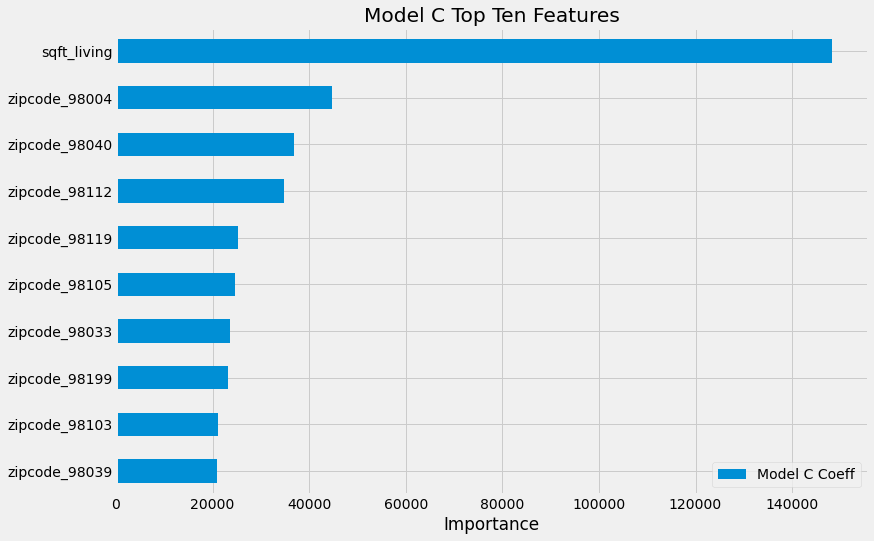

In [95]:
top_ten_features(model_c_lr, features_train_c, 'Model C Coeff', 'Model C Top Ten Features')

 - The most important feature according to Model C is square foot living followed by zip codes. 

In [96]:
y_train_pred_c = model_c_lr.predict(X_train_scaled_c)
y_test_pred_c = model_c_lr.predict(X_test_scaled_c)

In [97]:
errors(y_train_2, y_train_pred_c, y_test_2, y_test_pred_c)

Train Mean Absolute Error: 81908
Test Mean Absolute Error: 83185
Train Mean Squared Error: 14047121215
Test Mean Squared Error: 14687536061
Train Root Mean Squared Error: 118521
Test Root Mean Squared Error: 121192


 - On average Model C predicts home prices within $83,185 of the actual home value.

In [98]:
resid_c = y_test_pred_c - y_test_2

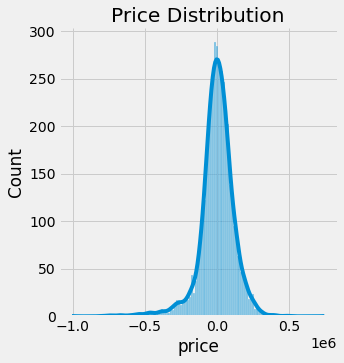

In [99]:
sns.displot(x=resid_c,kind='hist',kde=True)
plt.title('Price Distribution');

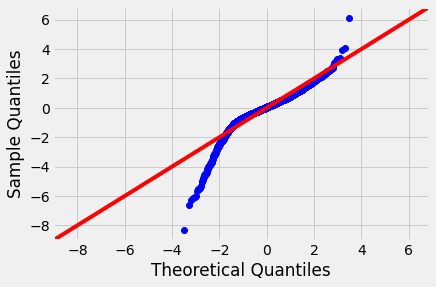

In [100]:
fig = sm.graphics.qqplot(resid_c, dist=stats.norm, line='45',fit=True)

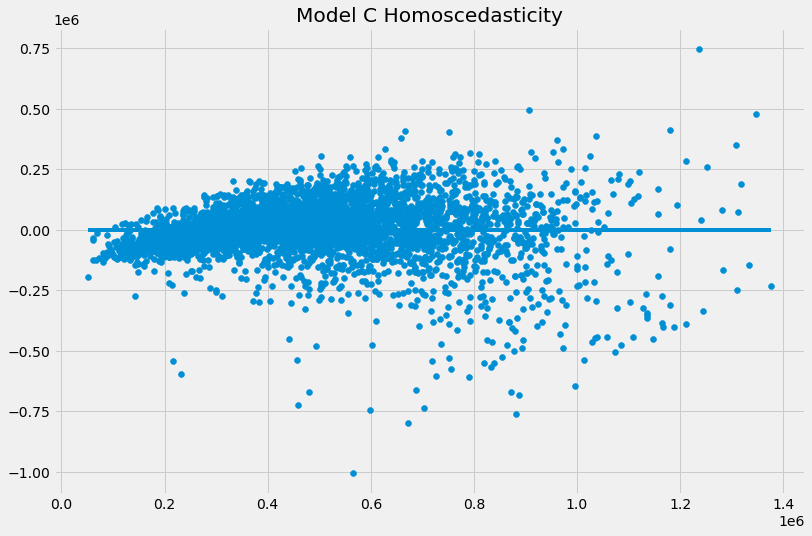

In [101]:
plot_scatter(y_test_pred_c, resid_c, 'Model C Homoscedasticity')

- Model C's data also appears to be more homoscedastic than both Model's A and B.

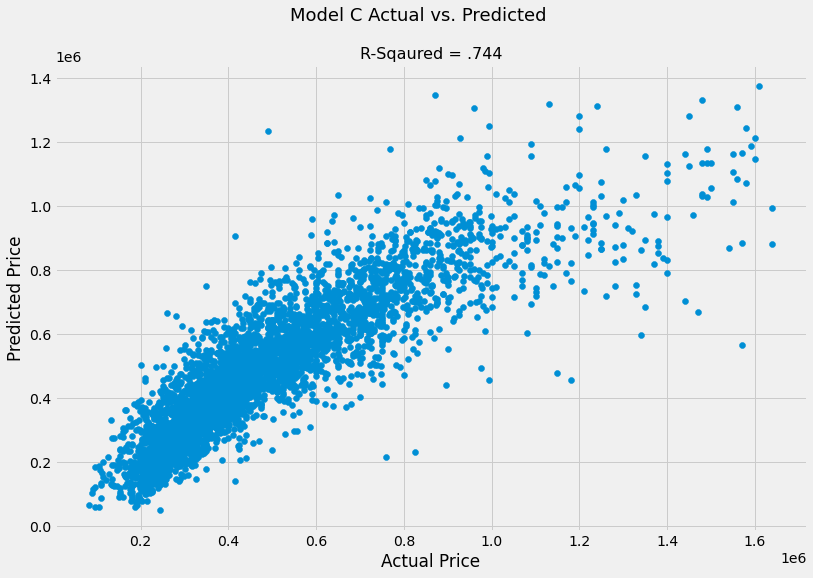

In [147]:
plot_model(y_test_2, y_test_pred_c, 'R-Sqaured = .744', 'Model C Actual vs. Predicted')

 - Model C also follows a somewhat better linear pattern than both Model's A and B.

# Model D

 - Because removing outliers did not significantly help with improving skew and kurtosis in Model C, one issue could be including too many zip code categorical features. For Model D the zip codes will be removed and replaced with a feature that measures the distance of the homes from Seattle. I would expect that as distance towards the city decreases, the price of the home should increase.

## Feature Engineering

 - Will create a new feature consisting of the sum of sqft living and the average sqft living of the nearest 15 neighbors. This should give a better idea of the price due to the grouping of homes in neighborhoods with larger homes also in the area. Will also create a new feature measuring each home's distance from Seattle. These new features will replace the zip code categorical fetaures from the previous models. 

In [103]:
sum_sqft_liv = outliers_df_2['sqft_living'] + outliers_df_2['sqft_living15']
outliers_df_2['sum_sqft_liv'] = sum_sqft_liv
outliers_df_2.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,...,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,sum_sqft_liv
0,221900.0,3,1.00,1180,5650,1.0,3,7,1180,1955,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2520
1,538000.0,3,2.25,2570,7242,2.0,3,7,2170,1951,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4260
2,180000.0,2,1.00,770,10000,1.0,3,6,770,1933,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3490
3,604000.0,4,3.00,1960,5000,1.0,5,7,1050,1965,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3320
4,510000.0,3,2.00,1680,8080,1.0,3,8,1680,1987,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3480


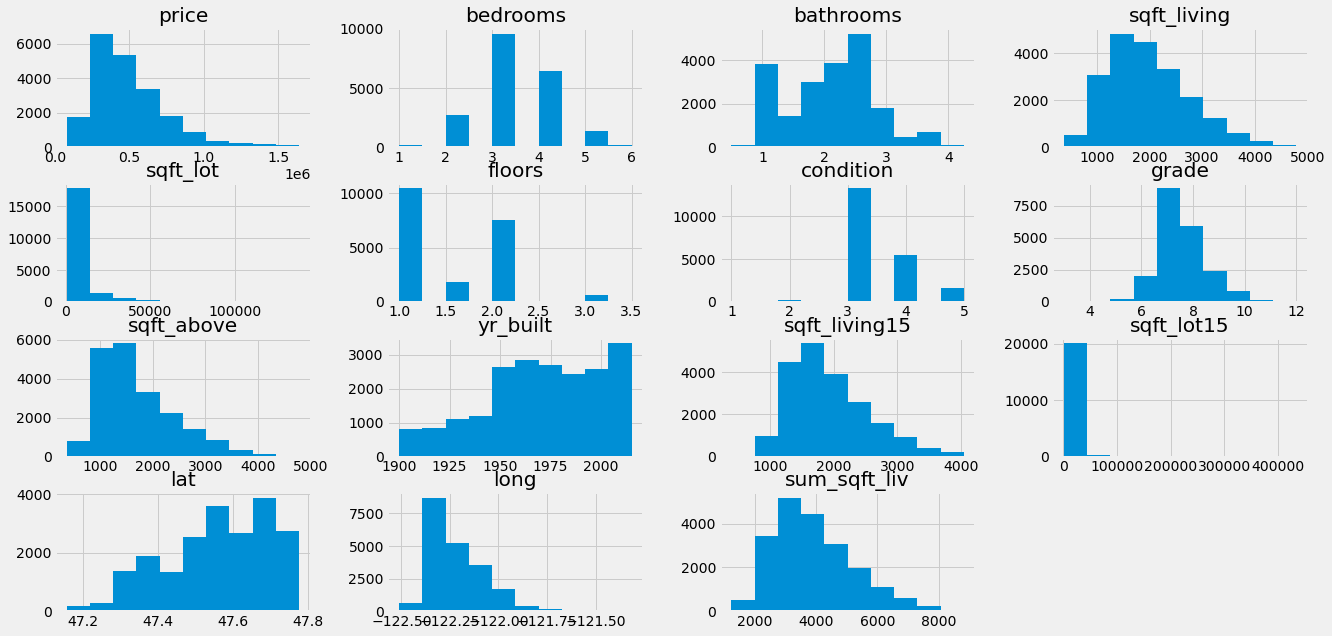

In [104]:
fig = plt.figure(figsize = (20,10))
ax = fig.gca()
outliers_df_2[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'condition', 'grade', 'sqft_above', 'yr_built', 'sqft_living15',
       'sqft_lot15', 'lat', 'long', 'sum_sqft_liv']].hist(ax = ax);

In [105]:
#Seattle Longitude/Latitude
start_lat, start_long = 47.6062, 122.3321

In [106]:
lat_a = outliers_df_2['lat']
long_a = outliers_df_2['long']

In [107]:
homes_lat_long = pd.concat([lat_a, long_a], axis=1)
homes_lat_long.head()

,lat,long
0,47.5112,-122.257
1,47.7210,-122.319
2,47.7379,-122.233
3,47.5208,-122.393
4,47.6168,-122.045


In [108]:
#Create a list of each home's distance from Seattle in km: 
distances_km = []
for row in homes_lat_long.itertuples(index=False):
   distances_km.append(
       haversine_distance(start_lat, start_long, row.lat, row.long)
   )

In [109]:
homes_lat_long['Distance_From_Seattle'] = distances_km

In [110]:
homes_lat_long.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20531 entries, 0 to 21596
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   lat                    20531 non-null  float64
 1   long                   20531 non-null  float64
 2   Distance_From_Seattle  20531 non-null  float64
dtypes: float64(3)
memory usage: 641.6 KB


In [111]:
final_df = pd.concat([outliers_df_2, homes_lat_long], axis=1)
final_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,...,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,sum_sqft_liv,lat,long,Distance_From_Seattle
0,221900.0,3,1.00,1180,5650,1.0,3,7,1180,1955,...,0.0,0.0,1.0,0.0,0.0,0.0,2520,47.5112,-122.257,7735.02
1,538000.0,3,2.25,2570,7242,2.0,3,7,2170,1951,...,0.0,0.0,0.0,0.0,0.0,0.0,4260,47.7210,-122.319,7714.28
2,180000.0,2,1.00,770,10000,1.0,3,6,770,1933,...,0.0,0.0,0.0,0.0,0.0,0.0,3490,47.7379,-122.233,7717.04
3,604000.0,4,3.00,1960,5000,1.0,5,7,1050,1965,...,0.0,0.0,0.0,0.0,0.0,0.0,3320,47.5208,-122.393,7727.57
4,510000.0,3,2.00,1680,8080,1.0,3,8,1680,1987,...,0.0,0.0,0.0,0.0,0.0,0.0,3480,47.6168,-122.045,7736.42


## Model D Training

In [112]:
target_d = final_df['price']
features_d = final_df.drop(['price'], axis=1)

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(features_d,target_d,test_size=0.2,random_state=42)

In [113]:
features_train_d = X_train_3[['bedrooms', 'bathrooms', 'floors', 'condition', 'grade', 'sqft_above', 'yr_built', 'sqft_living15', 'Distance_From_Seattle']]

In [114]:
features_test_d = X_test_3[['bedrooms', 'bathrooms', 'floors', 'condition', 'grade', 'sqft_above', 'yr_built', 'sqft_living15', 'Distance_From_Seattle']]

In [115]:
#Scale testing and training features
scale_features = StandardScaler()
scale_features.fit(features_train_d)
X_train_scaled_d = scale_features.transform(features_train_d)
X_test_scaled_d = scale_features.transform(features_test_d)

In [116]:
X_train_scaled_d = pd.DataFrame(X_train_scaled_d, columns = features_train_d.columns)

In [117]:
ols_model_3(X_train_scaled_d)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              y_train_3   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     3464.
Date:                Thu, 11 Nov 2021   Prob (F-statistic):               0.00
Time:                        10:05:58   Log-Likelihood:            -2.1871e+05
No. Observations:               16424   AIC:                         4.374e+05
Df Residuals:                   16414   BIC:                         4.375e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              4.563e+07   6.64e+05     68.674      0.000    4.43e+07    4.69e+07
bedrooms              -7736.4154   1656.398     -4.671      0.000    -1.1e+04   -4489.695
bathrooms              6.636e+04   2583.896     25.683      0.000    6.13e+04    7.14e+04
floors                 3822.7511   2911.715      1.313      0.189   -1884.527    9530.029
condition              3.347e+04   1932.557     17.319      0.000    2.97e+04    3.73e+04
grade                  9.777e+04   1804.483     54.182      0.000    9.42e+04    1.01e+05
sqft_above               56.7205      3.025     18.750      0.000      50.791      62.650
yr_built              -2368.3268     55.572    -42.617      0.000   -2477.254   -2259.400
sqft_living15            90.1715      2.983     30.232      0.000      84.325      96.018
Distance_From_Seattle -5393.0804     89.955    -59.953      0.000   -5569.401   -5216.760
==============================================================================
Omnibus:                     3883.294   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13142.115
Skew:                           1.181   Prob(JB):                         0.00
Kurtosis:                       6.691   Cond. No.                     4.86e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.86e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [118]:
model_d_lr = LinearRegression()
model_d_lr.fit(X_train_scaled_d ,y_train_3)

LinearRegression()

## Model D Evalutation

In [119]:
#Model D Intercept
print(model_d_lr.intercept_)

497409.45981490216


In [120]:
coef_df_d = pd.DataFrame(model_d_lr.coef_, features_train_d.columns, columns = ['Model D Coefficents']) 
coef_df_d

,Model D Coefficents
bedrooms,-6640.422002
bathrooms,46402.672299
floors,2059.342433
condition,21697.232764
grade,103540.594084
sqft_above,40473.359478
yr_built,-69570.133486
sqft_living15,54944.562757
Distance_From_Seattle,-77396.841992


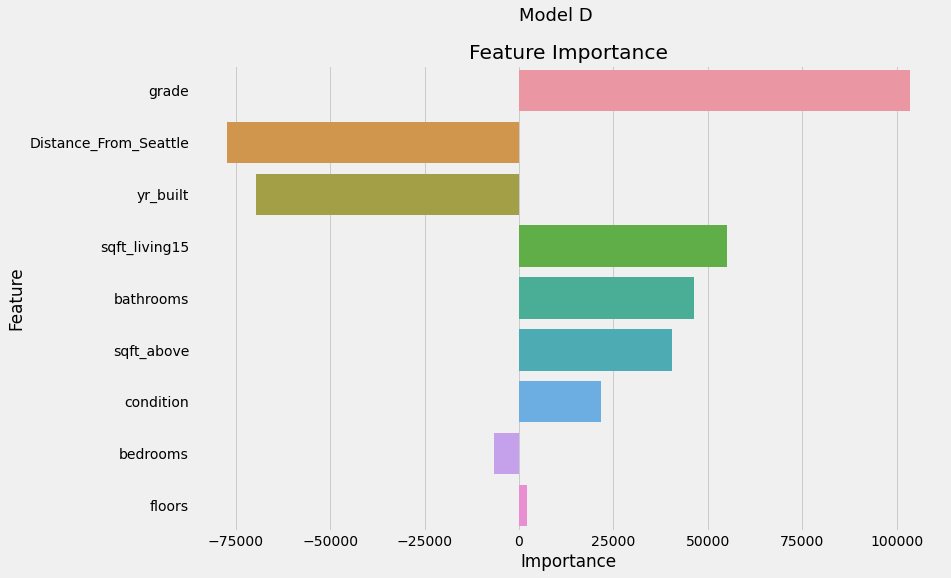

In [121]:
plot_feature_imp(features_train_d, model_d_lr, 'Feature Importance', 'Model D')

 - According to Model D the most important feature for predicting home price is Grade, followed by Distance from Seattle and Year Built.

In [122]:
y_train_pred_d = model_d_lr.predict(X_train_scaled_d)
y_test_pred_d = model_d_lr.predict(X_test_scaled_d)

In [123]:
errors(y_train_3, y_train_pred_d, y_test_3, y_test_pred_d)

Train Mean Absolute Error: 107017
Test Mean Absolute Error: 106695
Train Mean Squared Error: 21583283173
Test Mean Squared Error: 21624092902
Train Root Mean Squared Error: 146913
Test Root Mean Squared Error: 147051


 - On average on Model D predicts home prices within $106,695 of the actual home value.

In [124]:
resid_d = y_test_pred_d - y_test_3

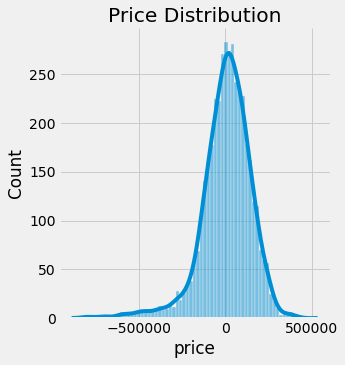

In [125]:
sns.displot(x=resid_d,kind='hist',kde=True)
plt.title('Price Distribution');

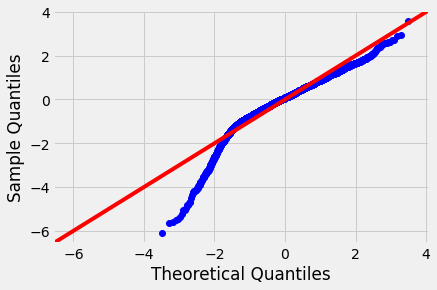

In [126]:
fig = sm.graphics.qqplot(resid_d, dist=stats.norm, line='45',fit=True)

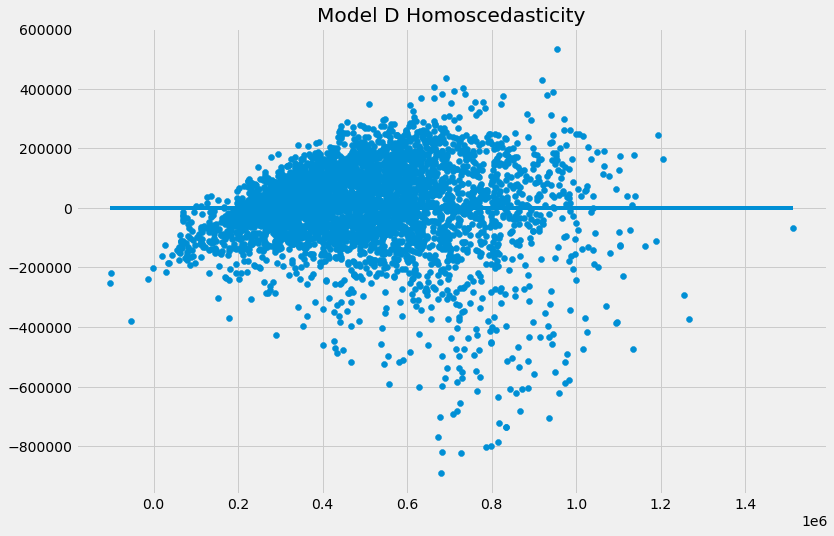

In [127]:
plot_scatter(y_test_pred_d, resid_d, 'Model D Homoscedasticity')

- Model D appears to be more homoscedastic than all previous models.

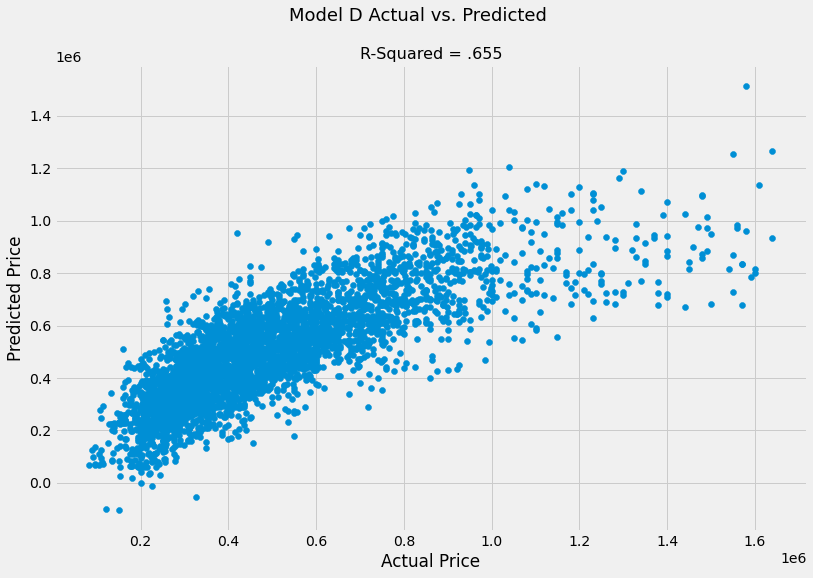

In [148]:
plot_model(y_test_3, y_test_pred_d, 'R-Squared = .655', 'Model D Actual vs. Predicted')

 - Model D also follows a somewhat better linear pattern than the earlier models.

## Conclusions/Summary

 - Comparison of model metrics as well as review of top features according to the models.

### Model Comparison

In [129]:
data = {'R-Squared':[.623, .744, .744, .655],
       'Skew':[3.188, 3.869, 3.866, 1.181],
       'Kurtosis':[34.842, 47.712, 47.694, 6.691],
       'MAE (test data)':[145718, 109632, 83185, 106695],
       'Feature 1':['Square Foot Living', 'Zip Code 98103', 'Square Foot Living', 'Grade'],
       'Feature 2':['Grade', 'Zip Code 98115', 'Zip Code 98004', 'Distance From Seattle'],
       'Feature 3':['Year Built', 'Zip Code 98038', 'Zip Code 98040', 'Year Built']}
model_comparison = pd.DataFrame(data, index=['Model A', 'Model B', 'Model C', 'Model D'])
model_comparison

,R-Squared,Skew,Kurtosis,MAE (test data),Feature 1,Feature 2,Feature 3
Model A,0.623,3.188,34.842,145718,Square Foot Living,Grade,Year Built
Model B,0.744,3.869,47.712,109632,Zip Code 98103,Zip Code 98115,Zip Code 98038
Model C,0.744,3.866,47.694,83185,Square Foot Living,Zip Code 98004,Zip Code 98040
Model D,0.655,1.181,6.691,106695,Grade,Distance From Seattle,Year Built


 - While Models B and C produce the highest R-Squared metric, they also have a high skew and kurtosis likely due to the presence of outliers as well as the uneven distribution of homes within the zip code categorial columns. Once the outliers and zip code columns were removed for Model D, both the skew and kurtosis significantly decreased making for a more reliable model.


 - Aside from zip codes; Square Foot Living, Grade, and Year Built all appear in the top three features for multiple models making these features the most important in predicting home price according to the models. Also once zip codes were replaced with the new 'Distance from Seattle' feature in Model D, we can see that this feature ranked second in terms of importance.


 - According to the models we can infer that home size, location, age, and 'grade' are the most important features in accurately predicting home value for King County. 

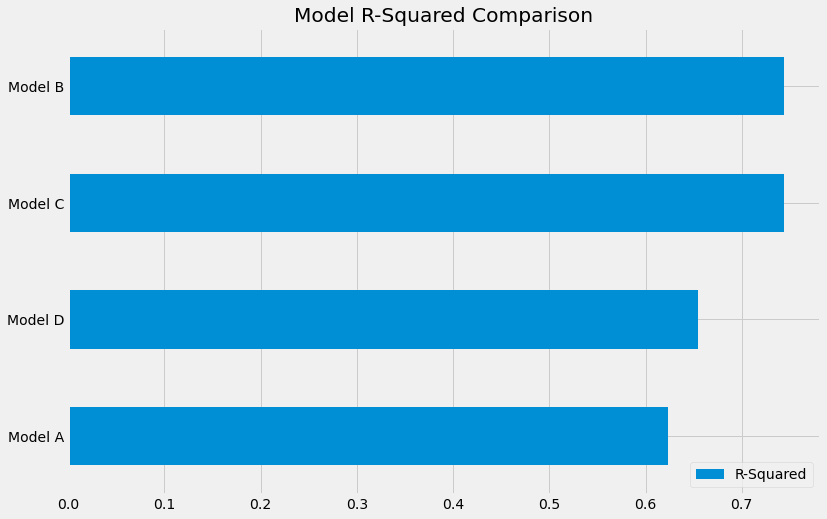

In [130]:
r_squared = pd.DataFrame(model_comparison['R-Squared'].sort_values(ascending=False))
ax = r_squared.sort_values('R-Squared').plot.barh(y='R-Squared', figsize=(12,8))
plt.title('Model R-Squared Comparison');

 - Models B and C both feature the highest R-Squared at .744 each. While Model A Features the lowest R-Squared at .623. Model D, the most accurate model in terms of skew and kurotsis comes in at .655.

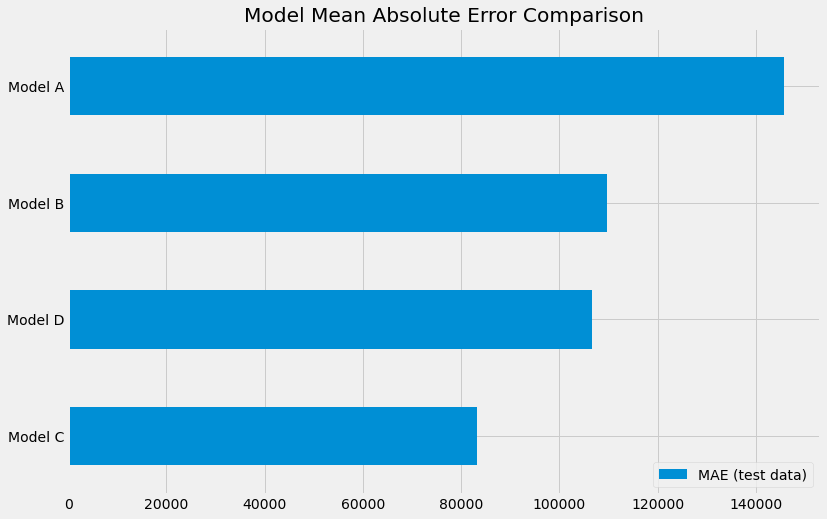

In [131]:
mae = pd.DataFrame(model_comparison['MAE (test data)'].sort_values(ascending=True))
ax = mae.sort_values('MAE (test data)').plot.barh(y='MAE (test data)', figsize=(12,8))
plt.title('Model Mean Absolute Error Comparison');

 - Overall the best MAE score was Model C, which on average predicts home values within 83,185 dollars of the actual home value. While the worst performing model according to MAE was model A, which on average predicts home values within 145,718 dollars of the actual home value. 

### Top Features (Non-Zipcode)

 - While zip codes are clearly an important feature in predicting home value according to the models, they also may be skewing the model likely due to the presence of higher value homes in generally lower value zip codes as well as lower value homes in generally higher value zip codes. Because of this we will look at the top non-zipcode features according to the models. 

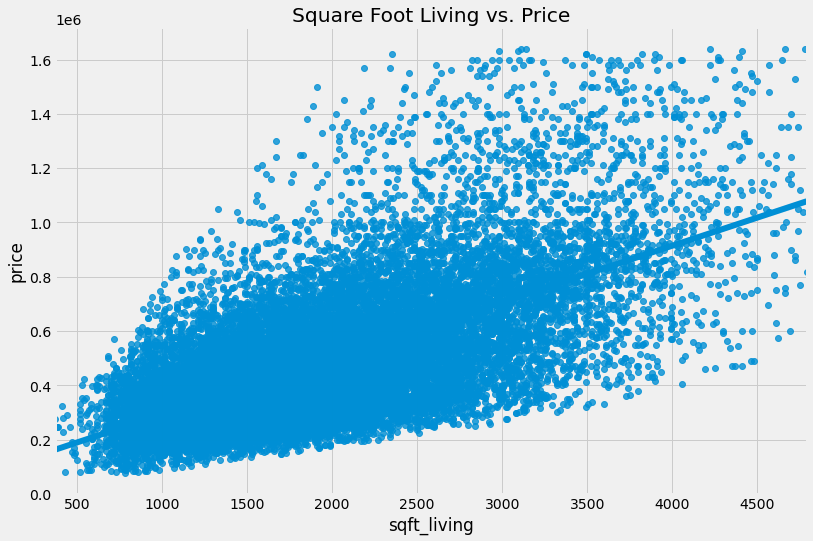

In [132]:
x = final_df['sqft_living']
y = final_df['price']
plt.figure(figsize=(12,8))
plt.xlabel('Square Foot Living')
plt.ylabel('Home Price')
plt.title('Square Foot Living vs. Price')
sns.regplot(x, y);

 - According to the graph, as sqaure foot living increases the price of the home also tends to increase.
 
 
 - Square Foot Living was the top feature in both models A and C.

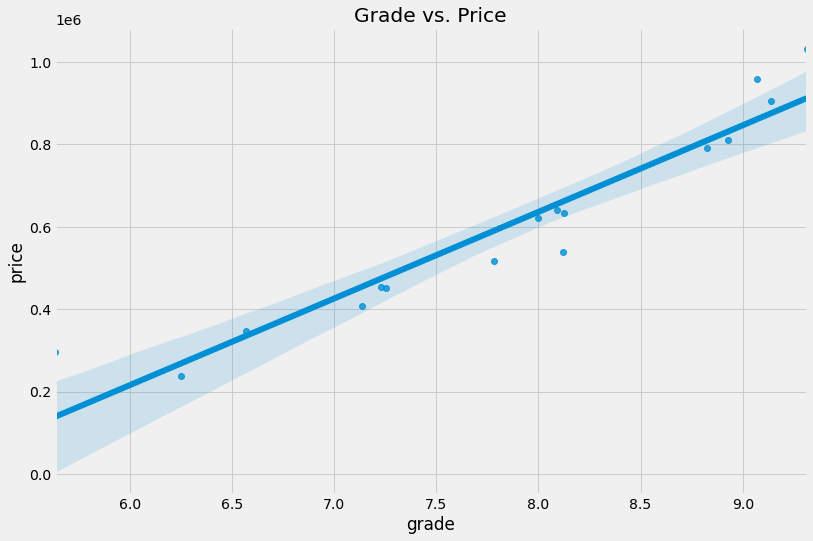

In [133]:
grouped_grade = final_df.groupby('bathrooms').mean()
grouped_grade.reset_index(inplace=True)
x = grouped_grade['grade']
y = grouped_grade['price']
plt.figure(figsize=(12,8))
plt.xlabel('Grade')
plt.ylabel('Home Price')
plt.title('Grade vs. Price')
sns.regplot(x, y);

 - According to the graph, as the 'grade' of the home increases the price of the home also tends to increase.
 
 
 - Grade was the top feature of Model D as well as the second most important feature for Model A.

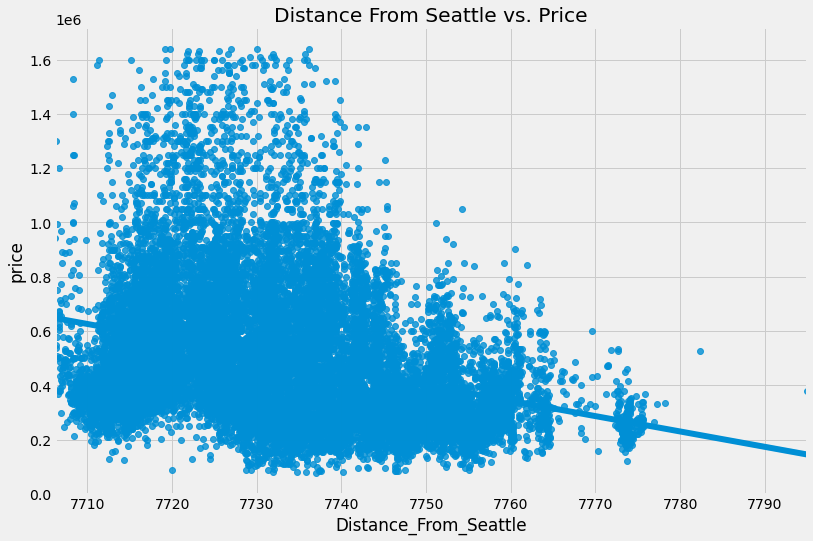

In [134]:
x = final_df['Distance_From_Seattle']
y = final_df['price']
plt.figure(figsize=(12,8))
plt.xlabel('Distance From Seattle')
plt.ylabel('Home Price')
plt.title('Distance From Seattle vs. Price')
sns.regplot(x, y);

 - According to the graph, as the distance from Seattle decreases the price of the home tends to generally increase.
 
 
 - Distance from Seattle was the second most important feature for Model D.

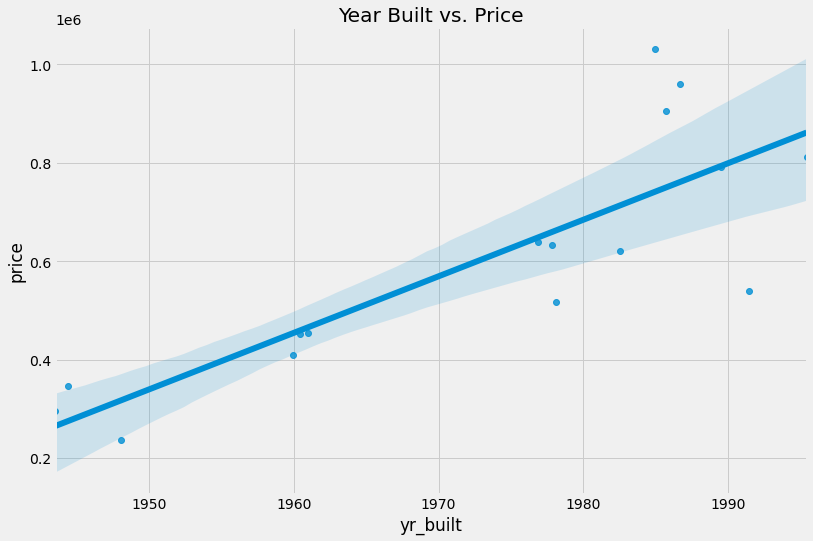

In [135]:
grouped_yr = final_df.groupby('yr_built').mean()
grouped_yr.reset_index(inplace=True)
x = grouped_grade['yr_built']
y = grouped_grade['price']
plt.figure(figsize=(12,8))
plt.xlabel('Year Built')
plt.ylabel('Home Price')
plt.title('Year Built vs. Price')
sns.regplot(x, y);

- According to the graph, as the year the home was built increases the price of the home also tends to generally increase.


- Year Built was the third most important feature for both Models A and D.